In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.imports import *
from fastai.structured import *
from IPython.display import display
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

In [7]:
PATH = "data/"

In [87]:
!ls {PATH}

GCP-Coupons-Instructions.rtf
sample_submission.csv
test.csv
train.csv
train.csv.zip


### Inital Processing

In [88]:
df_raw = pd.read_csv(f'{PATH}train.csv', nrows=5, parse_dates=["pickup_datetime"], infer_datetime_format=True)

In [89]:
df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [90]:
df_raw.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [91]:
types = {
    'key': 'object',
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

In [92]:
%%time
df_raw = pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], nrows=100000, dtype=types, infer_datetime_format=True)

Wall time: 581 ms


In [93]:
df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


In [94]:
df_raw = df_raw.drop("key", axis=1)
add_datepart(df_raw, "pickup_datetime")

In [96]:
train_cats(df_raw)

In [97]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/taxifare-raw')

#### Investigate the dates of the test set

In [110]:
test_raw = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], nrows=1000000, dtype=types, infer_datetime_format=True)
add_datepart(test_raw, 'pickup_datetime')
train_cats(test_raw)
test_raw['pickup_datetimeYear'].value_counts()

2011    2050
2014    1902
2010    1753
2012    1433
2013    1135
2009    1022
2015     619
Name: pickup_datetimeYear, dtype: int64

A validation set with random sampling should be sufficient, rather than picking out a particular range.

### Preprocessing

In [40]:
df_raw = pd.read_feather('tmp/taxifare-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'fare_amount')

C:\Users\RYAN\Anaconda3\envs\fastai\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [41]:
df_trn.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,pickup_datetimeDayofweek,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed
0,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,25,15,0,166,False,False,False,False,False,False,1245086781
1,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,1,5,1,5,False,False,False,False,False,False,1262710336
2,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,33,18,3,230,False,False,False,False,False,False,1313627700
3,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,16,21,5,112,False,False,False,False,False,False,1334982642
4,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,10,9,1,68,False,False,False,False,False,False,1268121060


In [42]:
TEST_SET_SIZE = pd.read_csv(f'{PATH}test.csv').shape[0]
TEST_SET_SIZE

9914

In [43]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = TEST_SET_SIZE
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [44]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [45]:
df, y, nas = proc_df(df_raw, 'fare_amount')

In [54]:
set_rf_samples(20000)

In [68]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[4.164867268412564, 4.701862285893264, 0.8152336710757253, 0.7772489763117175, 0.7681381330157062]


In [69]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 421 ms


(6.918110716002329, 3.177502616151906)

In [70]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [71]:
x.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,...,pickup_datetimeDayofyear,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeElapsed,pred_std,pred
90086,5.5,-73.992218,40.735466,-73.993080,40.742752,1,2014,10,40,5,...,278,False,False,False,False,False,False,1412532180,3.177503,6.918111
90087,5.5,-73.955238,40.768875,-73.946030,40.781654,1,2014,11,46,12,...,316,False,False,False,False,False,False,1415807220,1.662261,6.376250
90088,8.9,-74.011414,40.702774,-73.994431,40.697819,2,2010,6,22,3,...,154,False,False,False,False,False,False,1275600900,2.774200,7.180375
90089,9.7,-74.002426,40.730270,-73.970581,40.750027,1,2010,1,2,15,...,15,False,False,False,False,False,False,1263599820,2.642517,9.375831
90090,4.9,-73.976898,40.758301,-73.983200,40.757301,0,2011,12,50,12,...,346,False,False,False,False,False,False,1323694016,2.405255,7.075731


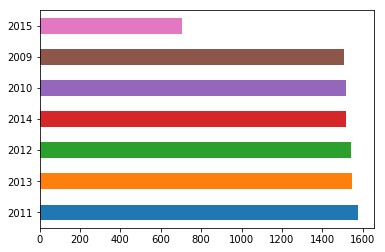

In [72]:
x.pickup_datetimeYear.value_counts().plot.barh();

Observation: This dataset was probably from mid2015?

In [74]:
flds = ['pickup_datetimeYear', 'fare_amount', 'pred', 'pred_std']
enc_summ = x[flds].groupby('pickup_datetimeYear', as_index=False).mean()
enc_summ

,pickup_datetimeYear,fare_amount,pred,pred_std
0,2009,10.098784,10.184671,2.864729
1,2010,10.574871,10.502778,2.909199
2,2011,10.813268,10.577982,2.930206
3,2012,11.133830,11.188655,3.162782
4,2013,12.456712,12.421775,3.390082
5,2014,13.006529,13.038433,3.424106
6,2015,13.031700,13.120143,3.660750


Observation: Predictions getting worse as years go by?

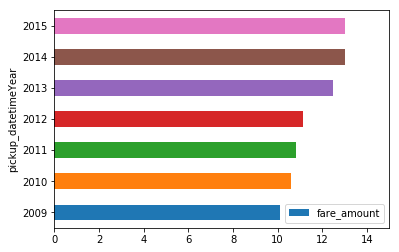

In [73]:
enc_summ = enc_summ[~pd.isnull(enc_summ.fare_amount)]
enc_summ.plot('pickup_datetimeYear', 'fare_amount', 'barh', xlim=(0,15));

Seems like its because fares as increasing as the years pass. Inflation?

In [75]:
flds = ['passenger_count', 'fare_amount', 'pred', 'pred_std']
enc_summ2 = x[flds].groupby('passenger_count', as_index=False).mean()
enc_summ2

,passenger_count,fare_amount,pred,pred_std
0,0,8.678947,8.890867,2.174856
1,1,11.397937,11.381230,3.118453
2,2,11.743926,11.691616,3.153221
3,3,11.297582,10.882450,2.974959
4,4,12.055929,11.834594,3.301532
5,5,11.667740,11.813871,3.496981
6,6,11.426666,11.901273,3.493200


Predictions getting worse as passenger count increases. Is this a common trend for anything that increases?

In [76]:
flds = ['pickup_datetimeDayofweek', 'fare_amount', 'pred', 'pred_std']
enc_summ3 = x[flds].groupby('pickup_datetimeDayofweek', as_index=False).mean()
enc_summ3

,pickup_datetimeDayofweek,fare_amount,pred,pred_std
0,0,12.002239,11.825002,3.280573
1,1,11.180158,11.276598,3.143052
2,2,11.637222,11.479207,3.121717
3,3,11.470254,11.304681,3.085571
4,4,11.113894,11.142808,3.020492
5,5,11.307266,11.376477,3.184490
6,6,11.658839,11.833551,3.274009


### Feature Importance

In [77]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
2,dropoff_longitude,0.306157
0,pickup_longitude,0.277842
3,dropoff_latitude,0.182274
1,pickup_latitude,0.145978
17,pickup_datetimeElapsed,0.032431
8,pickup_datetimeDay,0.012407
10,pickup_datetimeDayofyear,0.011398
5,pickup_datetimeYear,0.008878
9,pickup_datetimeDayofweek,0.007486
7,pickup_datetimeWeek,0.007431


In [79]:
x.dtypes.size

21

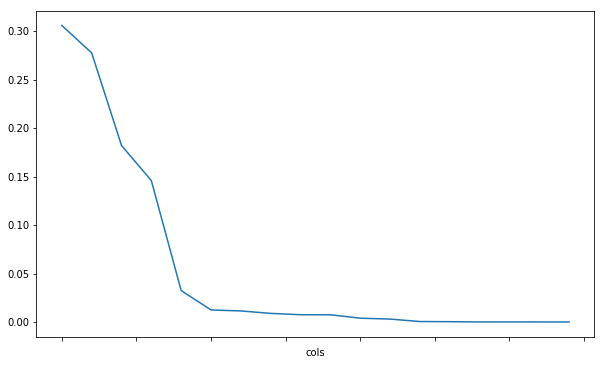

In [78]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);


In [84]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

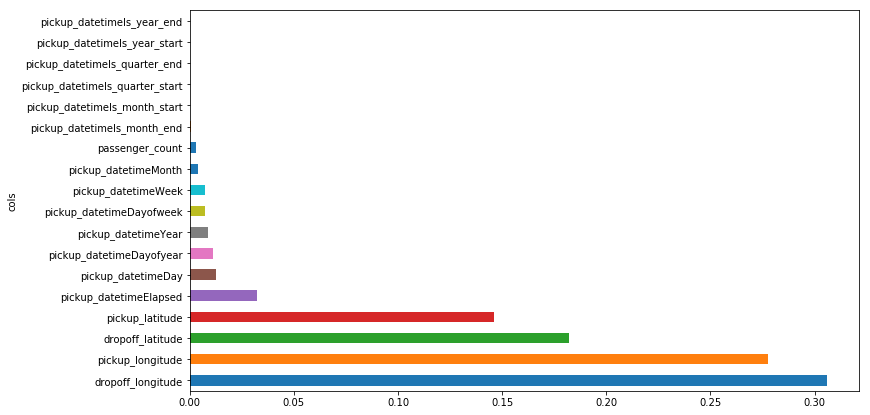

In [83]:
plot_fi(fi[:30]);

East - West NYC is more important than North - South

In [81]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

10

In [80]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [82]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[4.131598220483709, 4.613076995329656, 0.8181737161122448, 0.7855819679803884, 0.7697680882981542]


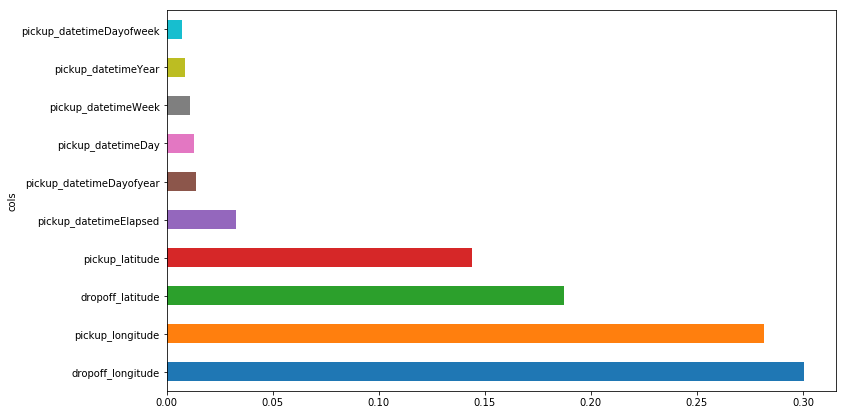

In [86]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Feature importance didnt seem to change that much